# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb
- homework_differentiation.ipynb

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules.ipynb

Optimizer is implemented for you. 

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

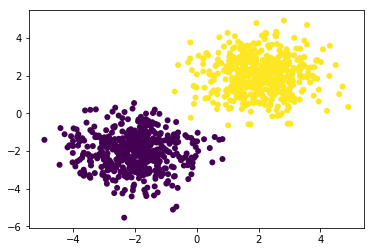

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [5]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [7]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

In [8]:
def train(net, criterion, X, y, n_epoch=20, batch_size=128, learning_rate=1e-1, momentum=0.9, visualize=True):
    optimizer_config = {'learning_rate' : learning_rate, 'momentum': momentum}
    optimizer_state = {}
    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, y), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            loss_history.append(loss)

    if visualize:
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()

        print('Current loss: %f' % loss)

        return loss_history

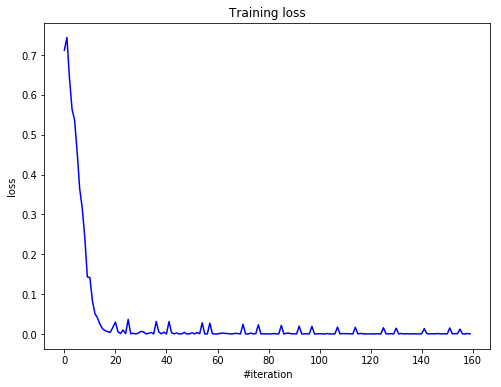

Current loss: 0.000048


In [9]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [10]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

One-hot encode the labels first.

In [11]:
from sklearn.preprocessing import OneHotEncoder

y_onehot = OneHotEncoder(sparse=False).fit_transform(y.reshape(-1, 1))
y_onehot

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

In [12]:
import time

losses = {}
times = {}

def train_net(name, activation_layer, use_batchnorm):
    net = Sequential()
    net.add(Linear(784, 200))
    if use_batchnorm:
        net.add(BatchNormalization(0.9))
        net.add(ChannelwiseScaling(200))
    net.add(activation_layer)
    net.add(Linear(200, 10))
    net.add(SoftMax())

    criterion = ClassNLLCriterion()
    optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
    optimizer_state = {}
    
    loss_history = []
    time_history = []

    for i in range(n_epoch):
        start = time.time()
        batches = list(get_batches((X, y_onehot), batch_size))
        n_batches = len(batches)
        for j, (x_batch, y_batch) in enumerate(batches):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)
            if j % 100 == 0:
                print(f'\rn_epoch={i + 1}/{n_epoch} [batch {j + 1}/{n_batches}], current_loss={loss}', end='')

        end = time.time()
        predictions = net.forward(X)
        loss = criterion.forward(predictions, y_onehot)
        t = end - start
        loss_history.append(loss)
        time_history.append(t)
        print(f'\rn_epoch={i + 1}/{n_epoch}, loss={loss}, time={t:.2f}s' + ' '*20)
    
    losses[name] = loss_history
    times[name] = time_history
    
def print_losses(keys=None):
    plt.figure()
    plt.xlabel('n_epoch')
    plt.ylabel('Loss')
    for name in losses if keys is None else keys:
        loss = losses[name]
        xs = range(len(loss))
        plt.plot(xs, loss, label=name)
    plt.legend()

def print_times(keys=None):
    plt.figure()
    plt.xlabel('n_epoch')
    plt.ylabel('time')
    for name in times if keys is None else keys:
        t = times[name]
        xs = range(len(t))
        plt.plot(xs, t, label=name)
    plt.legend()

In [52]:
train_net("ReLU", ReLU(), use_batchnorm=False)

n_epoch=1/20, loss=-0.8434118792630722, time=5.43s                                                  
n_epoch=2/20, loss=-0.9262077048680075, time=5.30s                                                  
n_epoch=3/20, loss=-0.9417577506427304, time=5.68s                                                  
n_epoch=4/20, loss=-0.952846155542213, time=5.44s                                                  
n_epoch=5/20, loss=-0.9590068113391381, time=5.24s                                                  
n_epoch=6/20, loss=-0.9631559136931699, time=5.26s                                                  
n_epoch=7/20, loss=-0.9693518736679816, time=5.20s                                                  
n_epoch=8/20, loss=-0.97222736482046, time=5.25s                                                  
n_epoch=9/20, loss=-0.9724834826774826, time=5.22s                                                  
n_epoch=10/20, loss=-0.9772075330918181, time=5.22s                                           

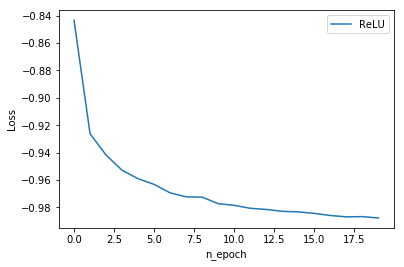

In [53]:
print_losses()

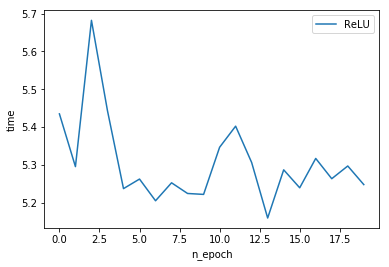

In [54]:
print_times()

In [55]:
train_net("ReLU_with_batchnorm", ReLU(), use_batchnorm=True)

n_epoch=1/20, loss=-0.9115766240102852, time=6.02s                                                  
n_epoch=2/20, loss=-0.9408732096621455, time=5.97s                                                  
n_epoch=3/20, loss=-0.9560685327951389, time=6.27s                                                  
n_epoch=4/20, loss=-0.965138627416562, time=6.13s                                                  
n_epoch=5/20, loss=-0.9698897450490404, time=6.20s                                                  
n_epoch=6/20, loss=-0.9747107337587619, time=6.03s                                                  
n_epoch=7/20, loss=-0.9778559189205249, time=6.06s                                                  
n_epoch=8/20, loss=-0.9796437428803715, time=6.15s                                                  
n_epoch=9/20, loss=-0.9818850159384682, time=6.10s                                                  
n_epoch=10/20, loss=-0.9839656311359797, time=5.98s                                         

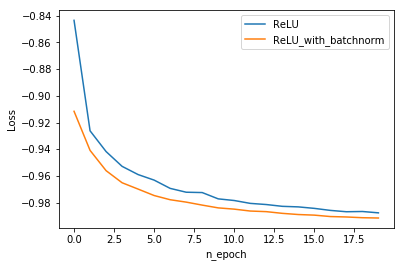

In [56]:
print_losses()

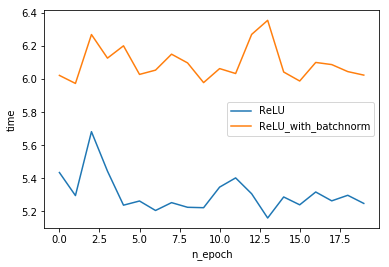

In [57]:
print_times()

In [58]:
train_net("ELU", ELU(), use_batchnorm=False)

n_epoch=1/20, loss=-0.9005943791236144, time=5.77s                                                  
n_epoch=2/20, loss=-0.9179935047940294, time=5.71s                                                  
n_epoch=3/20, loss=-0.9304074406579391, time=5.90s                                                  
n_epoch=4/20, loss=-0.9401454546845965, time=6.05s                                                  
n_epoch=5/20, loss=-0.946176436775725, time=5.79s                                                  
n_epoch=6/20, loss=-0.9510979054217886, time=5.66s                                                  
n_epoch=7/20, loss=-0.9566481853019694, time=5.75s                                                  
n_epoch=8/20, loss=-0.9605158836650253, time=5.74s                                                  
n_epoch=9/20, loss=-0.9615440701651923, time=5.76s                                                  
n_epoch=10/20, loss=-0.9667911255986066, time=5.88s                                         

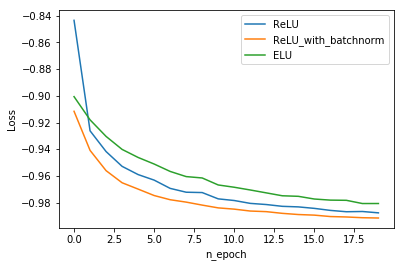

In [59]:
print_losses()

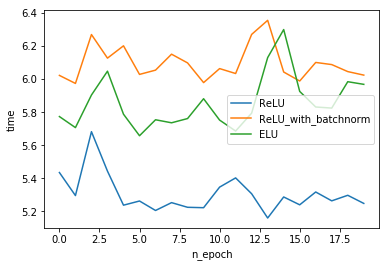

In [60]:
print_times()

In [61]:
train_net("ELU_with_batchnorm", ELU(), use_batchnorm=True)

n_epoch=1/20, loss=-0.908277371067652, time=6.74s                                                  
n_epoch=2/20, loss=-0.9270823814889158, time=6.61s                                                  
n_epoch=3/20, loss=-0.940443723078747, time=6.73s                                                  
n_epoch=4/20, loss=-0.9482249826730117, time=6.87s                                                  
n_epoch=5/20, loss=-0.9559658598487517, time=6.85s                                                  
n_epoch=6/20, loss=-0.9617051568833267, time=7.02s                                                  
n_epoch=7/20, loss=-0.9657665725187533, time=7.15s                                                  
n_epoch=8/20, loss=-0.96981058848335, time=6.96s                                                  
n_epoch=9/20, loss=-0.9722367800098118, time=7.24s                                                  
n_epoch=10/20, loss=-0.9748813982167613, time=7.04s                                            

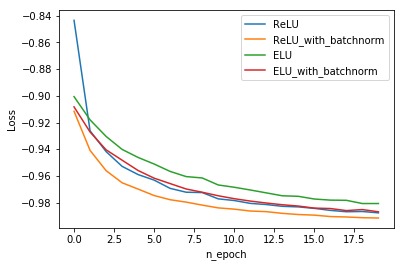

In [62]:
print_losses()

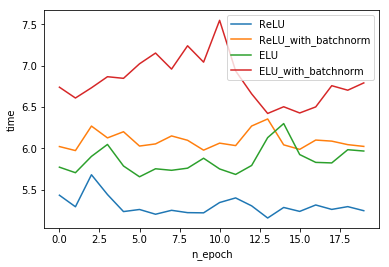

In [63]:
print_times()

In [64]:
train_net("LeakyReLU", LeakyReLU(), use_batchnorm=False)

n_epoch=1/20, loss=-0.8412824227690427, time=5.20s                                                  
n_epoch=2/20, loss=-0.8521827296144096, time=5.37s                                                  
n_epoch=3/20, loss=-0.8625830120373926, time=5.31s                                                  
n_epoch=4/20, loss=-0.9306368428270064, time=5.41s                                                  
n_epoch=5/20, loss=-0.948952407369652, time=5.30s                                                  
n_epoch=6/20, loss=-0.9580027634926009, time=5.35s                                                  
n_epoch=7/20, loss=-0.9626893237620451, time=5.49s                                                  
n_epoch=8/20, loss=-0.9672541175062371, time=5.38s                                                  
n_epoch=9/20, loss=-0.9709593055268552, time=5.49s                                                  
n_epoch=10/20, loss=-0.9736373152404487, time=5.52s                                         

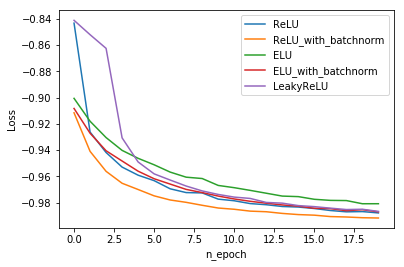

In [65]:
print_losses()

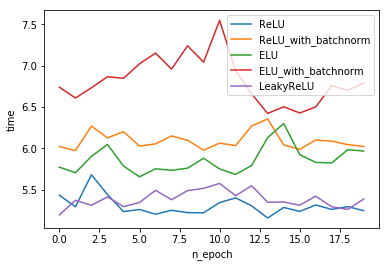

In [66]:
print_times()

In [67]:
train_net("LeakyReLU_with_batchnorm", LeakyReLU(), use_batchnorm=True)

n_epoch=1/20, loss=-0.9088926114518552, time=6.23s                                                  
n_epoch=2/20, loss=-0.9393177271664247, time=6.36s                                                  
n_epoch=3/20, loss=-0.9554276014623949, time=6.25s                                                  
n_epoch=4/20, loss=-0.9649229494955867, time=6.16s                                                  
n_epoch=5/20, loss=-0.9701634838851662, time=6.33s                                                  
n_epoch=6/20, loss=-0.9739444489156699, time=6.21s                                                  
n_epoch=7/20, loss=-0.9772763356913272, time=6.13s                                                  
n_epoch=8/20, loss=-0.9804548770215155, time=6.07s                                                  
n_epoch=9/20, loss=-0.9810231680449668, time=6.10s                                                  
n_epoch=10/20, loss=-0.9831082860012412, time=6.02s                                        

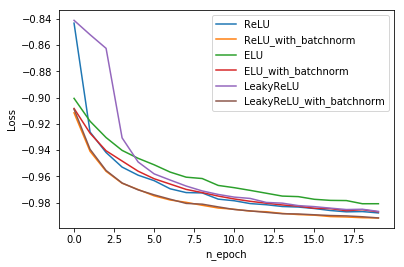

In [68]:
print_losses()

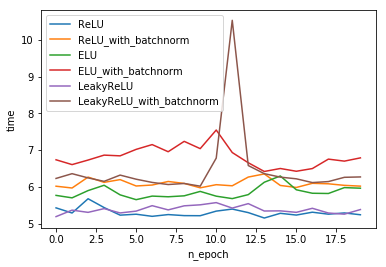

In [69]:
print_times()

In [70]:
train_net("SoftPlus", SoftPlus(), use_batchnorm=False)

n_epoch=1/20, loss=-0.4879701848629948, time=5.94s                                                  
n_epoch=2/20, loss=-0.5788479568179735, time=5.88s                                                  
n_epoch=3/20, loss=-0.5871624025414721, time=5.88s                                                  
n_epoch=4/20, loss=-0.6539762502971069, time=5.70s                                                  
n_epoch=5/20, loss=-0.6606208029987366, time=5.73s                                                  
n_epoch=6/20, loss=-0.6633452926457963, time=5.81s                                                  
n_epoch=7/20, loss=-0.6682406518008929, time=5.80s                                                  
n_epoch=8/20, loss=-0.6708989112583151, time=5.77s                                                  
n_epoch=9/20, loss=-0.6734659773372546, time=5.82s                                                  
n_epoch=10/20, loss=-0.6761959423650438, time=5.84s                                        

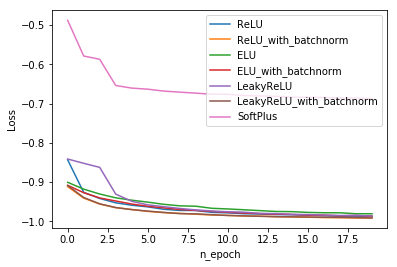

In [71]:
print_losses()

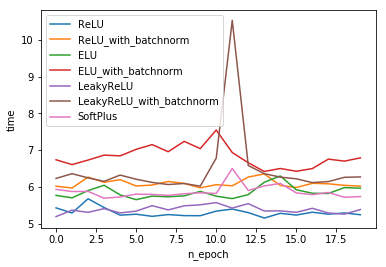

In [72]:
print_times()

In [73]:
train_net("SoftPlus_with_batchnorm", SoftPlus(), use_batchnorm=True)

n_epoch=1/20, loss=-0.30127940640913625, time=6.51s                                                  
n_epoch=2/20, loss=-0.7998287470832157, time=6.58s                                                  
n_epoch=3/20, loss=-0.8379482029558238, time=6.93s                                                  
n_epoch=4/20, loss=-0.8504376135088935, time=6.79s                                                  
n_epoch=5/20, loss=-0.85528765570734, time=6.66s                                                  
n_epoch=6/20, loss=-0.8631240241081987, time=6.94s                                                  
n_epoch=7/20, loss=-0.8665096101424345, time=6.54s                                                  
n_epoch=8/20, loss=-0.871092965447809, time=6.57s                                                  
n_epoch=9/20, loss=-0.9514123940802344, time=6.58s                                                  
n_epoch=10/20, loss=-0.9634409009124433, time=6.73s                                          

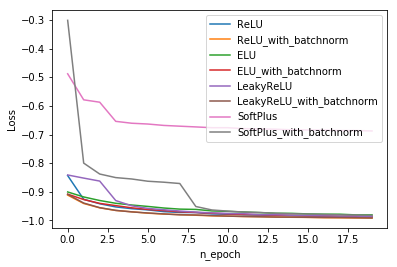

In [74]:
print_losses()

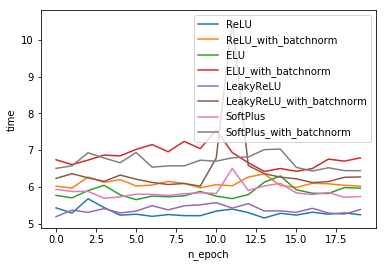

In [75]:
print_times()

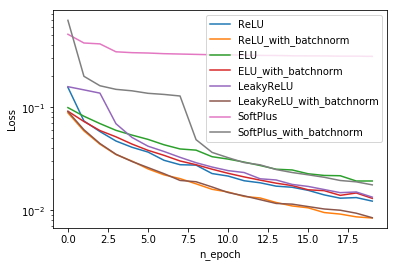

In [86]:
def print_losses_log(keys=None):
    plt.figure()
    plt.xlabel('n_epoch')
    plt.ylabel('Loss')
    
    plt.yscale('log')
    for name in losses if keys is None else keys:
        loss = list(map(lambda x: x + 1, losses[name]))
        xs = range(len(loss))
        plt.plot(xs, loss, label=name)
    plt.legend()
print_losses_log()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

По графику видно, что BatchNormalization слой помогает: для каждой функции активации аналог с батчнормализацей показывает лучшее качество. Видно также, что хуже всего ведет себя функция SoftPlus, лучше всего - ReLU. Также можно отметить, что аналоги с BatchNorm'ом отрабатывают одну эпоху где-то на одну секунду медленнее, чем без BatchNorm'а.

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [30]:
accuracies = {}
def print_accuracies(keys=None):
    plt.figure()
    plt.xlabel('n_epoch')
    plt.ylabel('Accuracy')
    for name in accuracies if keys is None else keys:
        accuracy = accuracies[name]
        xs = range(len(accuracy))
        plt.plot(xs, accuracy, label=name)
    plt.legend()

In [101]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot)

def train_net(name):
    net = Sequential()
    
    net.add(Linear(784, 200))
    net.add(BatchNormalization(0.9))
    net.add(ChannelwiseScaling(200))
    net.add(ReLU())
    
    net.add(Linear(200, 100))
    net.add(BatchNormalization(0.9))
    net.add(ChannelwiseScaling(100))
    net.add(ReLU())
    
    net.add(Linear(100, 10))
    net.add(SoftMax())

    criterion = ClassNLLCriterion()
    optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
    optimizer_state = {}
    
    loss_history_train = []
    loss_history_test = []
    accuracy_history_train = []
    accuracy_history_test = []
    time_history = []

    for i in range(n_epoch):
        start = time.time()
        batches = list(get_batches((X_train, y_train), batch_size))
        n_batches = len(batches)
        net.train()
        for j, (x_batch, y_batch) in enumerate(batches):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)
            if j % 100 == 0:
                print(f'\rn_epoch={i + 1}/{n_epoch} [batch {j + 1}/{n_batches}], current_loss={loss}', end='')

                
        predictions_train = net.forward(X_train)
        loss_train = criterion.forward(predictions_train, y_train)
        loss_history_train.append(loss_train)
        predictions_train = np.where(predictions_train == predictions_train.max(axis=1, keepdims=True), 1, 0)
        accuracy_history_train.append(accuracy_score(y_train, predictions_train))
        
        net.evaluate()
        predictions_test = net.forward(X_test)
        loss_test = criterion.forward(predictions_test, y_test)
        loss_history_test.append(loss_test)
        predictions_test = np.where(predictions_test == predictions_test.max(axis=1, keepdims=True), 1, 0)
        accuracy_history_test.append(accuracy_score(y_test, predictions_test))
        
        end = time.time()
        t = end - start
        time_history.append(t)
        
        print(f'\rn_epoch={i + 1}/{n_epoch}, loss_train={loss_train}, loss_test={loss_test}, time={t:.2f}s' + ' '*20)
    
    losses[f'{name}_train'] = loss_history_train
    losses[f'{name}_test'] = loss_history_test
    accuracies[f'{name}_train'] = accuracy_history_train
    accuracies[f'{name}_test'] = accuracy_history_test
    times[name] = time_history

In [102]:
train_net("SuperCoolModel")

n_epoch=1/20, loss_train=-0.9344695838399608, loss_test=-0.9315866493842175, time=7.12s                    
n_epoch=2/20, loss_train=-0.9677964577927091, loss_test=-0.9620864841076606, time=7.11s                    
n_epoch=3/20, loss_train=-0.9748936935223218, loss_test=-0.9652150919120016, time=7.02s                    
n_epoch=4/20, loss_train=-0.9790685828517266, loss_test=-0.9694738594136958, time=7.07s                    
n_epoch=5/20, loss_train=-0.9821067520927571, loss_test=-0.9717505727596745, time=6.98s                    
n_epoch=6/20, loss_train=-0.9837338808553927, loss_test=-0.9715138889353125, time=6.94s                    
n_epoch=7/20, loss_train=-0.9860873924028971, loss_test=-0.9730159484675894, time=7.00s                    
n_epoch=8/20, loss_train=-0.9883592127246372, loss_test=-0.9756597702819477, time=7.01s                    
n_epoch=9/20, loss_train=-0.9899262759029689, loss_test=-0.9772742689930426, time=6.92s                    
n_epoch=10/20, loss_train=-0

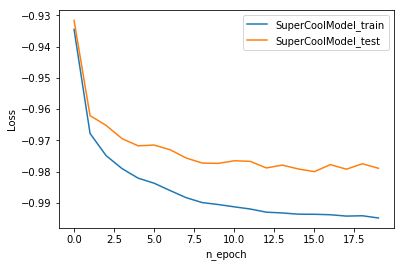

In [103]:
print_losses(['SuperCoolModel_train', 'SuperCoolModel_test'])

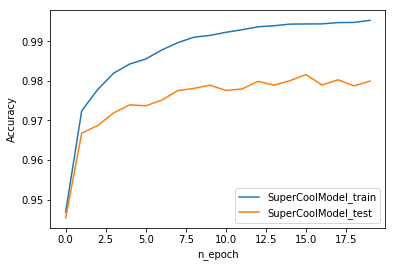

In [104]:
print_accuracies()

Print here your accuracy. It should be around 90%.

In [105]:
print(accuracies['SuperCoolModel_train'][-1], accuracies['SuperCoolModel_test'][-1])

0.9952952380952381 0.9799428571428571


# Autoencoder

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
<img src="autoencoder.png">

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use `MSECriterion` to score the reconstruction. Use `BatchNormalization` (followed by `ChannelwiseScaling` as usual) between `Linear` and `ReLU`. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot)

n_epoch = 9

net = Sequential()

net.add(Linear(784, 512))
net.add(BatchNormalization(0.9))
net.add(ChannelwiseScaling(512))
net.add(ReLU())

net.add(Linear(512, 256))
net.add(BatchNormalization(0.9))
net.add(ChannelwiseScaling(256))
net.add(ReLU())

net.add(Linear(256, 128))
net.add(BatchNormalization(0.9))
net.add(ChannelwiseScaling(128))
net.add(ReLU())

net.add(Linear(128, 30))

net.add(Linear(30, 128))
net.add(BatchNormalization(0.9))
net.add(ChannelwiseScaling(128))
net.add(ReLU())

net.add(Linear(128, 256))
net.add(BatchNormalization(0.9))
net.add(ChannelwiseScaling(256))
net.add(ReLU())

net.add(Linear(256, 512))
net.add(BatchNormalization(0.9))
net.add(ChannelwiseScaling(512))
net.add(ReLU())

net.add(Linear(512, 784))
net.add(BatchNormalization(0.9))
net.add(ChannelwiseScaling(784))
net.add(ReLU())

criterion = MSECriterion()

def train_net(name):
    optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
    optimizer_state = {}
    
    loss_history_train = []
    loss_history_test = []
    time_history = []

    for i in range(n_epoch):
        if ((i + 1) % 3) == 0:
            optimizer_config['learning_rate'] /= 2
        start = time.time()
        batches = list(get_batches((X_train, y_train), batch_size))
        n_batches = len(batches)
        net.train()
        for j, (x_batch, y_batch) in enumerate(batches):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, x_batch)

            # Backward
            dp = criterion.backward(predictions, x_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)
            if j % 100 == 0:
                print(f'\rn_epoch={i + 1}/{n_epoch} [batch {j + 1}/{n_batches}], current_loss={loss}', end='')

                
        predictions_train = net.forward(X_train)
        loss_train = criterion.forward(predictions_train, X_train)
        loss_history_train.append(loss_train)
        
        net.evaluate()
        predictions_test = net.forward(X_test)
        loss_test = criterion.forward(predictions_test, X_test)
        loss_history_test.append(loss_test)
        
        end = time.time()
        t = end - start
        time_history.append(t)
        
        print(f'\rn_epoch={i + 1}/{n_epoch}, loss_train={loss_train}, loss_test={loss_test}, time={t:.2f}s' + ' '*20)
    
    losses[f'{name}_train'] = loss_history_train
    losses[f'{name}_test'] = loss_history_test
    times[name] = time_history

In [16]:
train_net('autoencoder')

n_epoch=1/9, loss_train=33.60371910556493, loss_test=34.343695134611636, time=54.56s                    
n_epoch=2/9, loss_train=28.861803149054335, loss_test=29.952841565030244, time=67.10s                    
n_epoch=3/9, loss_train=26.124944624334052, loss_test=26.586530977416444, time=41.11s                    
n_epoch=4/9, loss_train=24.343621914024258, loss_test=24.634774533269397, time=42.23s                    
n_epoch=5/9, loss_train=23.037204910871864, loss_test=23.545530207039725, time=39.82s                    
n_epoch=6/9, loss_train=21.949162221974994, loss_test=22.372977369808623, time=40.00s                    
n_epoch=7/9, loss_train=21.643070554331693, loss_test=21.864614445798328, time=40.89s                    
n_epoch=8/9, loss_train=21.373455880727533, loss_test=21.685354149625617, time=40.68s                    
n_epoch=9/9, loss_train=20.869497426775272, loss_test=21.187201719013494, time=43.68s                    


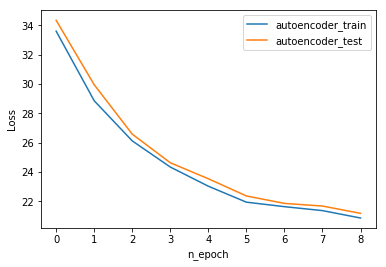

In [17]:
print_losses(['autoencoder_train', 'autoencoder_test'])

In [18]:
X_autoencoded = net.forward(X_test)

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [19]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices

net.forward(X_train)
X_train_repr = net.modules[12].output

net.forward(X_test)
X_test_repr = net.modules[12].output

X_train_repr.shape, X_test_repr.shape

((52500, 30), (17500, 30))

In [20]:
# Now build a logistic regression or small classification net
cnet = Sequential()
cnet.add(Linear(30, 10))
cnet.add(LogSoftMax())

ccriterion = ClassNLLCriterion()

# Learn the weights
def train_net(name, net, criterion):
    optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
    optimizer_state = {}
    
    loss_history_train = []
    loss_history_test = []
    time_history = []

    for i in range(n_epoch):
        if ((i + 1) % 3) == 0:
            optimizer_config['learning_rate'] /= 2
        start = time.time()
        batches = list(get_batches((X_train_repr, y_train), batch_size))
        n_batches = len(batches)
        net.train()
        for j, (x_batch, y_batch) in enumerate(batches):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)
            if j % 100 == 0:
                print(f'\rn_epoch={i + 1}/{n_epoch} [batch {j + 1}/{n_batches}], current_loss={loss}', end='')

                
        predictions_train = net.forward(X_train_repr)
        loss_train = criterion.forward(predictions_train, y_train)
        loss_history_train.append(loss_train)
        
        net.evaluate()
        predictions_test = net.forward(X_test_repr)
        loss_test = criterion.forward(predictions_test, y_test)
        loss_history_test.append(loss_test)
        
        end = time.time()
        t = end - start
        time_history.append(t)
        
        print(f'\rn_epoch={i + 1}/{n_epoch}, loss_train={loss_train}, loss_test={loss_test}, time={t:.2f}s' + ' '*20)
    
    losses[f'{name}_train'] = loss_history_train
    losses[f'{name}_test'] = loss_history_test
    times[name] = time_history

In [21]:
train_net('classification_net', cnet, ccriterion)

n_epoch=1/9, loss_train=5.958145888127169, loss_test=6.0336607807670655, time=1.08s                    
n_epoch=2/9, loss_train=6.207149772373787, loss_test=6.348963170115316, time=0.89s                    
n_epoch=3/9, loss_train=1.878375391245887, loss_test=1.9497694990837053, time=0.84s                    
n_epoch=4/9, loss_train=2.4159926544186656, loss_test=2.5195389442953227, time=0.85s                    
n_epoch=5/9, loss_train=2.1794546801906853, loss_test=2.3227820810341813, time=0.84s                    
n_epoch=6/9, loss_train=1.2911763634743918, loss_test=1.3607240421922928, time=0.83s                    
n_epoch=7/9, loss_train=1.2096825474433348, loss_test=1.2798782815961869, time=0.83s                    
n_epoch=8/9, loss_train=1.0270936085224327, loss_test=1.1196795549874325, time=0.83s                    
n_epoch=9/9, loss_train=0.7639796895199209, loss_test=0.8379512236413199, time=0.83s                    


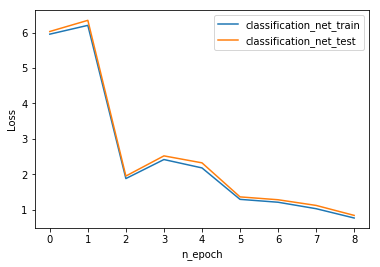

In [22]:
print_losses(['classification_net_train', 'classification_net_test'])

In [26]:
# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
autoenc = net
autoenc.modules = autoenc.modules[:13]

# And add learned layers ontop.
autoenc.add(cnet[0])
autoenc.add(cnet[1])
accuracies = {}

# Now optimize whole model
def train_net(name, net, criterion):
    optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
    optimizer_state = {}
    
    loss_history_train = []
    loss_history_test = []
    accuracy_history_train = []
    accuracy_history_test = []
    time_history = []

    for i in range(n_epoch):
        if ((i + 1) % 3) == 0:
            optimizer_config['learning_rate'] /= 2
        start = time.time()
        batches = list(get_batches((X_train, y_train), batch_size))
        n_batches = len(batches)
        net.train()
        for j, (x_batch, y_batch) in enumerate(batches):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)
            if j % 100 == 0:
                print(f'\rn_epoch={i + 1}/{n_epoch} [batch {j + 1}/{n_batches}], current_loss={loss}', end='')

                
        predictions_train = net.forward(X_train)
        loss_train = criterion.forward(predictions_train, y_train)
        loss_history_train.append(loss_train)
        predictions_train = np.where(predictions_train == predictions_train.max(axis=1, keepdims=True), 1, 0)
        accuracy_history_train.append(accuracy_score(y_train, predictions_train))
        
        net.evaluate()
        predictions_test = net.forward(X_test)
        loss_test = criterion.forward(predictions_test, y_test)
        loss_history_test.append(loss_test)
        predictions_test = np.where(predictions_test == predictions_test.max(axis=1, keepdims=True), 1, 0)
        accuracy_history_test.append(accuracy_score(y_test, predictions_test))
        
        end = time.time()
        t = end - start
        time_history.append(t)
        
        print(f'\rn_epoch={i + 1}/{n_epoch}, loss_train={loss_train}, loss_test={loss_test}, time={t:.2f}s' + ' '*20)
    
    losses[f'{name}_train'] = loss_history_train
    losses[f'{name}_test'] = loss_history_test
    accuracies[f'{name}_train'] = accuracy_history_train
    accuracies[f'{name}_test'] = accuracy_history_test
    times[name] = time_history

In [27]:
train_net('autoenc_classifier', autoenc, ccriterion)

n_epoch=1/9, loss_train=0.7499156244432494, loss_test=0.8789567707015451, time=16.86s                    
n_epoch=2/9, loss_train=0.8847298690433821, loss_test=0.8184936475026034, time=16.96s                    
n_epoch=3/9, loss_train=0.6395053894557979, loss_test=0.7430397819454231, time=17.86s                    
n_epoch=4/9, loss_train=1.0483685804799463, loss_test=1.0437921994533284, time=17.53s                    
n_epoch=5/9, loss_train=1.2744330897723284, loss_test=1.1024784678334227, time=17.01s                    
n_epoch=6/9, loss_train=0.5226386349247081, loss_test=0.626669608051926, time=17.78s                    
n_epoch=7/9, loss_train=0.6191604760419194, loss_test=0.7504903912585481, time=17.10s                    
n_epoch=8/9, loss_train=0.5425886886877891, loss_test=0.7133887681496585, time=18.84s                    
n_epoch=9/9, loss_train=0.46599272040509615, loss_test=0.6326194841134374, time=17.52s                    


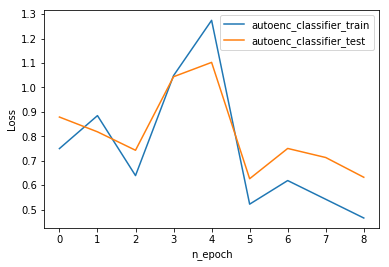

In [28]:
print_losses(['autoenc_classifier_train', 'autoenc_classifier_test'])

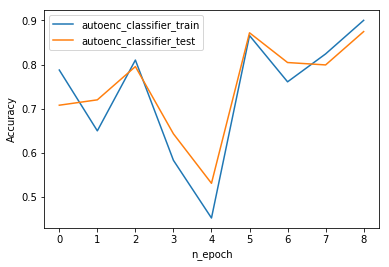

In [31]:
print_accuracies(['autoenc_classifier_train', 'autoenc_classifier_test'])

In [32]:
print(accuracies['autoenc_classifier_train'][-1], accuracies['autoenc_classifier_test'][-1])

0.9000952380952381 0.8746285714285714


* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Не имеет смысла строить подобные классификаторы в реальных задачах, так как они показывают качество ниже, чем обычная нейросеть.

Кроме производительности компьютеров, которая значительно выросла за 8 лет, также появились новые архитектуры нейронных сетей, которые способны быстрее и с более высоким качеством решать различные задачи. 

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [156]:
from sklearn.decomposition import PCA

pca = PCA(30).fit(X_train)
X_test_pca = pca.inverse_transform(pca.transform(X_test))

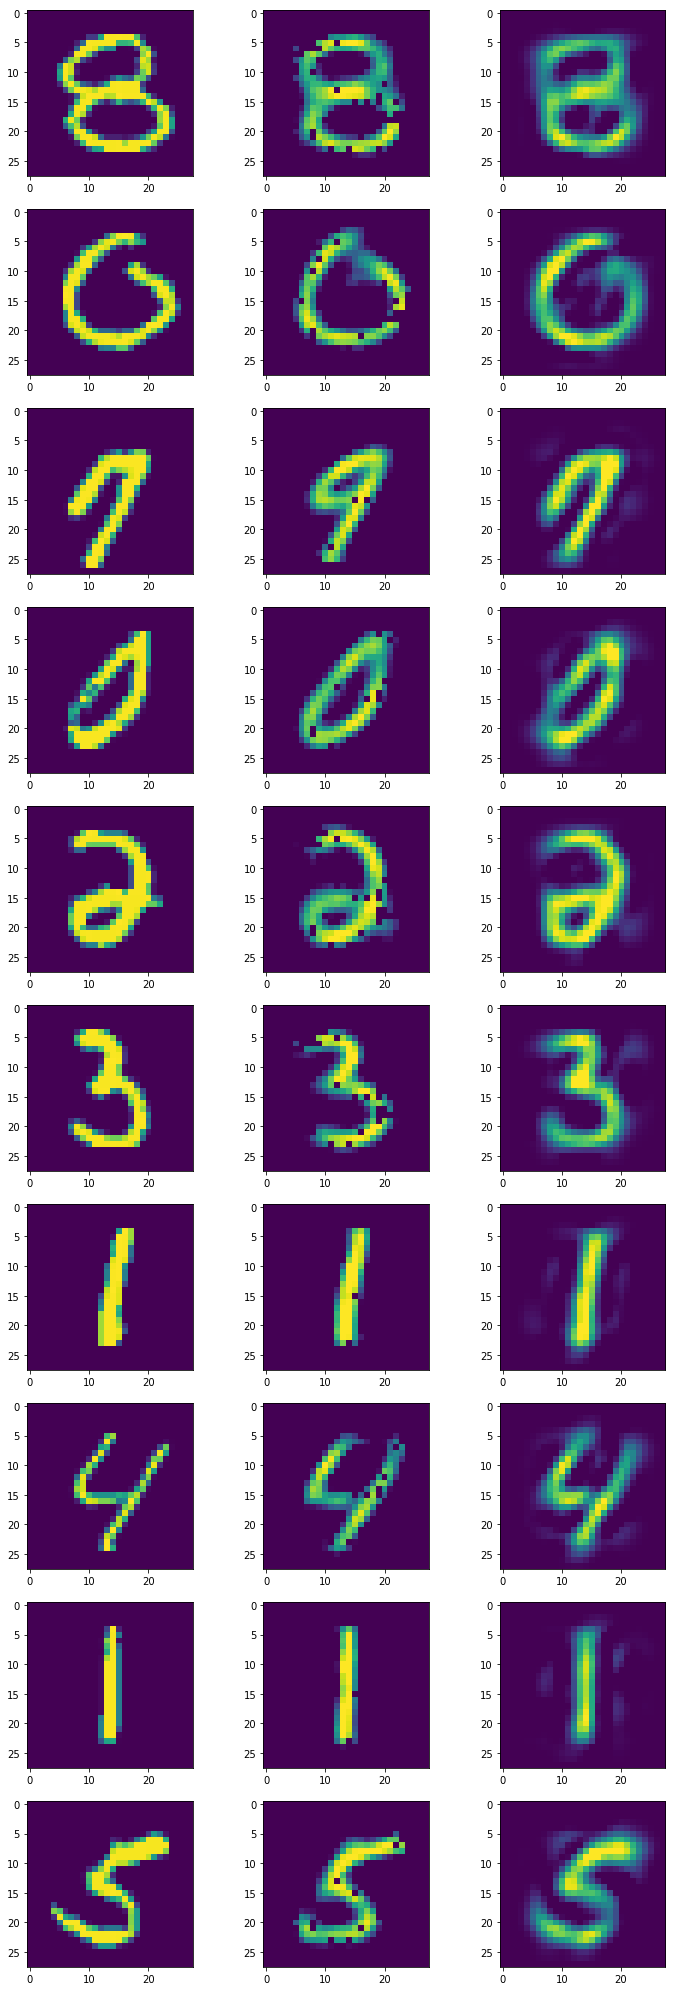

In [158]:
indicies = np.random.choice(X_test.shape[0], 10)
original_images = X_test[indicies]
autoencoded_images = np.clip(X_autoencoded[indicies], 0, 1)
pca_images = np.clip(X_test_pca[indicies], 0, 1)

fig=plt.figure(figsize=(12, 36))
columns = 3
rows = 10
for i, images in enumerate(zip(original_images, autoencoded_images, pca_images)):
    for j, img in enumerate(images):
        fig.add_subplot(rows, columns, i*3 + j + 1)
        plt.imshow(img.reshape(28, 28))
plt.show()